## <font color='darkblue'>Preface</font>
This notebook builds a deep neural network to perform more sophisticated linear regression than the earlier notebooks.

### <font color='darkgreen'>Learning Objectives:</font>

After doing this Colab, you'll know how to do the following:

  * Create a simple deep neural network.
  * Tune the hyperparameters for a simple deep neural network.

### <font color='darkgreen'>Call the import statements</font>
The following code imports the necessary modules.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Imported modules.


### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'><b><a href='#sect1'>The Dataset</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Intro to Neural Nets</a></b></font>

<a id='sect1'></a>
## <font color='darkblue'>The Dataset</font>

Like several of the previous exercises, this notebook uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

### <font color='darkgreen'>Load the datasets from the internet</font>
The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

### <font color='darkgreen'>Normalize values</font>

<font size='3ptx'><b>When creating a model with multiple features, the values of each feature should cover roughly the same range.</b></font>  For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should 
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model. 

The following code cell normalizes datasets by converting each raw value (<font color='brown'>including the label</font>) to its [Z-score](https://en.wikipedia.org/wiki/Standard_score). A [**Z-score**](https://en.wikipedia.org/wiki/Standard_score) is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

  * The mean is 60.
  * The standard deviation is 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

In [3]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2150,1.1,-1.1,-0.4,-0.3,-0.2,-0.5,-0.3,-0.8,2.5
13991,-1.2,0.9,-0.3,0.8,0.9,1.4,1.0,0.0,0.1
16734,-1.7,1.5,-0.7,-0.7,-0.7,-0.8,-0.7,-0.6,-0.9
4052,0.8,-0.9,-0.0,-0.6,-0.6,-0.5,-0.5,0.5,-0.2
14950,-1.3,2.3,-0.4,-0.2,-0.4,-0.4,-0.4,0.4,-0.8


In [4]:
# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


### <font color='darkgreen'>Represent data</font>

The following code cell creates a feature layer containing three features:

* `latitude` X `longitude` (a feature cross)
* `median_income`
* `population`

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (<font color='brown'>collected in `my_feature_layer`</font>) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 

In [5]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

<a id='sect2'></a>
## <font color='darkblue'>Intro to Neural Nets</font>
* <font size='3ptx'><b><a href='#sect2_1'>Build a linear regression model as a baseline</a></b></font>
* <font size='3ptx'><b><a href='#sect2_2'>Define a deep neural net model</a></b></font>
* <font size='3ptx'><b><a href='#sect2_3'>Define a training function</a></b></font>
* <font size='3ptx'><b><a href='#sect2_4'>Call the functions to build and train a deep neural net</a></b></font>
* <font size='3ptx'><b><a href='#sect2_5'>Task 1: Compare the two models</a></b></font>
* <font size='3ptx'><b><a href='#sect2_6'>Task 2: Optimize the deep neural network's topography</a></b></font>
* <font size='3ptx'><b><a href='#sect2_7'>Task 3: Regularize the deep neural network (if you have enough time) </a></b></font>

<a id='sect2_1'></a>
### <font color='darkgreen'>Build a linear regression model as a baseline</font>

Before creating a deep neural net, find a [baseline](https://developers.google.com/machine-learning/glossary/#baseline) loss by running a simple linear regression model that uses the feature layer you just created. 

#### Define the plotting function.

In [6]:
def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


#### Define functions to create and train a linear regression model

In [21]:
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=0)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


#### Train the model
Run the following code cell to invoke the the functions defined in the preceding two code cells. (Ignore the warning messages.)

**Note:** Because we've scaled all the input data, **including the label**, the resulting loss values will be *much less* than previous models. 

**Note:** Depending on the version of TensorFlow, running this cell might generate WARNING messages. Please ignore these warnings. 

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


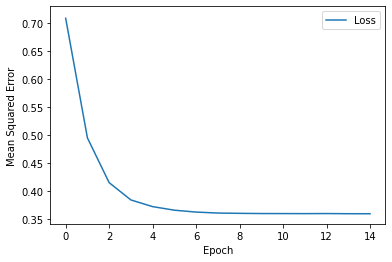


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 2ms/step - loss: 0.3952 - mean_squared_error: 0.3952
Loss=0.40; MSE=0.40


In [22]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
loss, mse = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)
print(f"Loss={loss:.02f}; MSE={mse:.02f}")

<a id='sect2_2'></a>
### <font color='darkgreen'>Define a deep neural net model</font>

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `create_model` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.

In [9]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

<a id='sect2_3'></a>
### <font color='darkgreen'>Define a training function</font>

The `train_model` function trains the model from the input features and labels. The [tf.keras.Model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) method performs the actual training. The `x` parameter of the `fit` method is very flexible, enabling you to pass feature data in a variety of ways. The following implementation passes a Python dictionary in which:

* The *keys* are the names of each feature (for example, `longitude`, `latitude`, and so on).
* The *value* of each key is a NumPy array containing the values of that feature. 

**Note:** Although you are passing *every* feature to `model.fit`, most of those values will be ignored. Only the features accessed by `my_feature_layer` will actually be used to train the model.

In [10]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None, val_pert=0.1):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=0) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

<a id='sect2_4'></a>
### <font color='darkgreen'>Call the functions to build and train a deep neural net</font>

Okay, it is time to actually train the deep neural net.  If time permits, experiment with the three hyperparameters to see if you can reduce the loss
against the test set.


Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


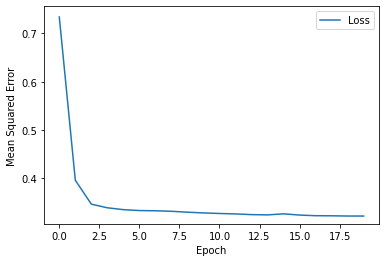


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 2ms/step - loss: 0.3636 - mean_squared_error: 0.3636
Loss=0.36; MSE=0.36


In [11]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
loss, mse = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)
print(f'Loss={loss:.02f}; MSE={mse:.02f}')

<a id='sect2_5'></a>
### <font color='darkgreen'>Task 1: Compare the two models</font> ([back](#sect2))

How did the deep neural net perform against the baseline linear regression model?

> Assuming that the linear model converged and
> the deep neural net model also converged, please 
> compare the test set loss for each.
> In our experiments, the loss of the deep neural 
> network model was consistently lower than 
> that of the linear regression model, which 
> suggests that the deep neural network model 
> will make better predictions than the 
> linear regression model.

<a id='sect2_6'></a>
### <font color='darkgreen'>Task 2: Optimize the deep neural network's topography</font> ([back](#sect2))

Experiment with the number of layers of the deep neural network and the number of nodes in each layer.  Aim to achieve both of the following goals:

*  Lower the loss against the test set.
*  Minimize the overall number of nodes in the deep neural net. 

The two goals may be in conflict.

> Many answers are possible.  We noticed the 
> following trends:
>   * Two layers outperformed one layer, but 
>     three layers did not perform significantly 
>     better than two layers; two layers 
>     outperformed one layer.
>     In other words, two layers seemed best. 
>   * Setting the topography as follows produced 
>     reasonably good results with relatively few 
>     nodes:
>       * 10 nodes in the first layer.
>       *  6 nodes in the second layer.
>     As the number of nodes in each layer dropped
>     below the preceding, test loss increased.  
>     However, depending on your application, hardware
>     constraints, and the relative pain inflicted 
>     by a less accurate model, a smaller network 
>     (for example, 6 nodes in the first layer and 
>     4 nodes in the second layer) might be 
>     acceptable.

<a id='sect2_7'></a>
### <font color='darkgreen'>Task 3: Regularize the deep neural network (if you have enough time)</font> ([back](#sect2))

<b><font color='darkred'>Notice that the model's loss against the test set is *much higher* than the loss against the training set</font></b>.  In other words, the deep neural network is **[overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) to the data in the training set**.  To reduce overfitting, regularize the model.  The course has suggested several different ways to regularize a model, including:

  * [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization)
  * [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization)
  * [Dropout regularization](https://developers.google.com/machine-learning/glossary/#dropout_regularization)

Your task is to experiment with one or more regularization mechanisms to bring the test loss closer to the training loss (<font color='brown'>while still keeping test loss relatively low</font>).

**<font color='darkred'>Note:</font>** When you add a regularization function to a model, you might need to tweak other hyperparameters. 

#### Implementing L1 or L2 regularization

To use L1 or L2 regularization on a hidden layer, specify the `kernel_regularizer` argument to [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Assign one of the following methods to this argument:

* `tf.keras.regularizers.l1` for L1 regularization
* `tf.keras.regularizers.l2` for L2 regularization

Each of the preceding methods takes an `l` parameter, which adjusts the [regularization rate](https://developers.google.com/machine-learning/glossary/#regularization_rate). Assign a decimal value between 0 and 1.0 to `l`; the higher the decimal, the greater the regularization. For example, the following applies L2 regularization at a strength of 0.05. 

```
model.add(tf.keras.layers.Dense(units=20, 
                                activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                name='Hidden1'))
```

#### Implementing Dropout regularization

You implement dropout regularization as a separate layer in the topography. For example, the following code demonstrates how to add a dropout regularization layer between the first hidden layer and the second hidden layer:

```
model.add(tf.keras.layers.Dense( *define first hidden layer*)
 
model.add(tf.keras.layers.Dropout(rate=0.25))

model.add(tf.keras.layers.Dense( *define second hidden layer*)
```

The `rate` parameter to [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) specifies the fraction of nodes that the model should drop out during training.

In [12]:
# The following "solution" uses L2 regularization to bring training loss
# and test loss closer to each other. Many, many other solutions are possible.

def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""

  # Discard any pre-existing version of the model.
  model = None

  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model. 

  # Implement L2 regularization in the first hidden layer.
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden1'))
  
  # Implement L2 regularization in the second hidden layer.
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden2'))

  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [13]:
train_df_norm.__class__

pandas.core.frame.DataFrame

In [14]:
def train_model_with_val(
  model, dataset, epochs, label_name, batch_size=None, val_pert=0.1):
  """Train the model by feeding it data."""
  dataset = dataset.sample(frac=1).reset_index(drop=True)
  cut_point = int(train_df_norm.shape[0] * (1-val_pert))
  
  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  train_dataset = dataset[:cut_point]
  val_dataset = dataset[cut_point:]  
  train_features = {name:np.array(value) for name, value in train_dataset.items()}
  val_features = {name:np.array(value) for name, value in val_dataset.items()}
    
  label = np.array(features.pop(label_name))
  train_label = np.array(train_features.pop(label_name))
  val_label = np.array(val_features.pop(label_name))
  
  #features = {name:np.array(value) for name, value in dataset.items()}
  #label = np.array(features.pop(label_name))
  
  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=0,
                      validation_data=(val_features, val_label)) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  return epochs, hist

In [15]:
def plot_the_loss_with_val_curve(epochs, history):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  mse = history["mean_squared_error"]
  val_mse = history["val_mean_squared_error"]
  plt.plot(epochs, mse, label="Loss")
  plt.plot(epochs, val_mse, label="Val loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

In [16]:
# Call the new create_model function and the other (unchanged) functions.

# The following variables are the hyperparameters.
learning_rate = 0.007
epochs = 140
batch_size = 1000

label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

In [17]:
# Train the model on the normalized training set.
epochs, history = train_model_with_val(
  my_model, train_df_norm, epochs, label_name, batch_size)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


In [18]:
history.head()

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,2.2,1.0,1.3,0.7
1,1.0,0.6,0.7,0.4
2,0.7,0.4,0.5,0.4
3,0.5,0.4,0.5,0.4
4,0.5,0.4,0.4,0.4


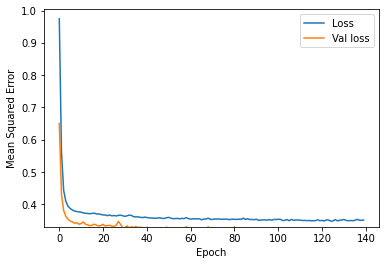

In [19]:
plot_the_loss_with_val_curve(epochs, history)

In [20]:
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size) 


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 3ms/step - loss: 0.4164 - mean_squared_error: 0.3818


[0.4164259135723114, 0.3818497359752655]